### Run Prediction on Test Data

In [22]:
from modules_lib.model import ModelWrapper
%load_ext autoreload
%autoreload 2
import sys
import os
# Laptop GPU is busy with rendering screen ...
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  
import pickle
import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

model_file_i = 'data/models/model_coords_0000'

model_wrapper = ModelWrapper(model_file_i)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded Model with settings:
	add_coordinates: True
	sensor_norm_file: data/normalization/sensor_normalization_eqFalse_trTrue_09092022.pkl


In [23]:
#from modules_lib.data import read_data
from modules_lib.data import KEYS as keys
from modules_lib.data import get_data_from_data_frame
from modules_lib.data import read_data


#test_file = '../summerschool2020/Robot_Data/test/test_data.csv'
test_file = '../../Coding/Dataset_sensor_floor/Dataset_Final/02092022/test/test.csv'

#frames_test, y_test, t_test, X_test = read_data(test_file)
frames_test, y_test, t_test, X_test = read_data(test_file)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/irfan-flw/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scal

In [24]:
#test predict
#missing nodes: 7-13, 20-9, 21-6, 23-5
low_thres = 0
up_thres = 999

#X_input_test = np.reshape(X_test[400], [-1, 23, 15, 10])
#t_input_test = np.reshape(t_test[400], [-1, 1])
mu = model_wrapper.predict(X_test[low_thres:up_thres], t_test[low_thres:up_thres])
#mu = model_wrapper.predict(X_input_test, t_input_test)
mu


X_shape predict: (999, 23, 15, 10)
Mean failed:
[ 2.38390988  2.08796466  2.02426933  2.13257485  2.41467568  2.22017618
  2.66298873  2.41658354  2.21750596  2.30947177  2.55120807 20.8783769
 15.66946594  2.5433829   2.54564909 46.40962829 29.75670605  3.05087083
  2.8174489   5.02979332  4.12874023  2.46216016  2.02948232  2.77946642
  2.42794917  2.22765048  2.38488873  2.46418303  2.00824314  2.05413024
  2.52340033  2.80014997  2.07109898  2.40492638  2.39941002  2.07806853
  2.76067944  2.47546153  2.51307389  2.38063457  2.41067326  4.44071521
  2.05571669  2.44012252  2.05855133  2.86539618  2.06182269  2.43622361
  2.58166894  2.20161087  2.02386444  2.01873093 10.63460041 12.26404996
  2.0265929   2.41861482  2.11407316  2.3074033   3.27232621  2.83547958
 18.06265808 26.49416744 31.62739505  2.14174985  2.05652448  2.05652395
  2.26703669  2.644689    2.46681252  2.17393596  2.21358924  2.24465499
  2.02562509  4.45091158  5.32047163  4.27188524  2.12953993  2.12896144
  2.

array([[-7.34974051, -1.66502678],
       [-7.34974051, -1.66502678],
       [-7.34974051, -1.66502678],
       ...,
       [-6.97783232,  2.02060819],
       [-8.03653431, -1.28357804],
       [-7.73842859, -1.44026208]])

Text(0.5, 1.0, 'Prediction vs Ground Truth')

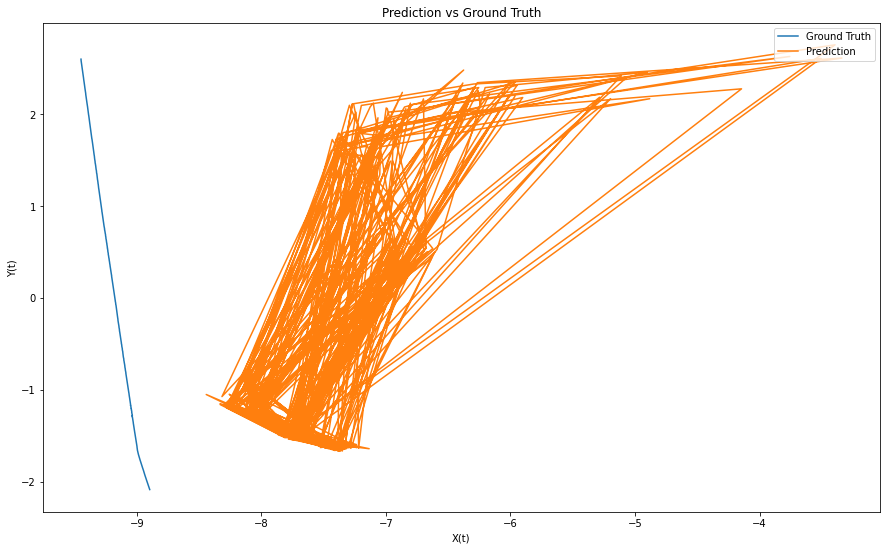

In [25]:
ground_truth = '../../Coding/Dataset_sensor_floor/Dataset_Final/02092022/test/ground_truth.csv'
df = pd.read_csv(ground_truth)

plt.figure(figsize=(15, 9))
plt.plot(df['vicon_x'].iloc[low_thres:up_thres], df['vicon_y'].iloc[low_thres:up_thres], label='Ground Truth')
plt.plot(mu[:,0], mu[:,1], label = 'Prediction')
# plt.xlim(-11.185, 10.185)
# plt.ylim(-6.425, 7.575)
plt.xlabel('X(t)')
plt.ylabel('Y(t)')
plt.legend(loc='upper right')
plt.title('Prediction vs Ground Truth')

In [ ]:
num_frames = 100
use_wrapper = True

y_test_pred = []

for split in tqdm(range(len(X_test_list))):
    X_test_i = np.array(X_test_list[split])
    t_test_i = np.array(t_test_list[split])
    y_test_i = np.array(y_test_list[split])
    
    if use_wrapper:
        mu = model_wrapper.predict(X_test_i, t_test_i)
    else:

        X_test_norm_i = np.array((X_test_i - sensor_bias) / sensor_std)
        X_test_norm_i[~np.isfinite(X_test_norm_i)] = 0
        X_test_norm_i = X_test_norm_i[..., 6:]

        y_test_pred_i = model.predict(X_test_norm_i)

        mu = y_test_pred_i[..., :2]
        sigma = y_test_pred_i[..., 2:4]
        r = y_test_pred_i[..., 4:]

        # Run Evaluation
        vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
        print(np.max(vel), np.max(acc))

        mu = postprocess(mu, sigma, r, t_test_i, 
                         pre_fitting_size=None)

    # Run Evaluation
    vel, acc = get_vel_and_acc(mu, t_test_i)[:2]
    print(np.max(vel), np.max(acc))
    
    # append reconstructed positions to list
    y_test_pred.append(mu)
    
    
y_test_pred = np.concatenate(y_test_pred, axis=0)

if False:
    create_complete_gif2(
        run, 
        file_name='plots/gif_test_{norm}.gif',
        normalized=True, num_frames=num_frames,
        y_pred=y_test_pred,
    )

In [ ]:
print(len(y_test_pred), len(X_test))
assert len(y_test_pred) == len(X_test), len(y_test_pred)

data_dict = {
    'frame_number': range(len(y_test_pred)),
    'vicon_x': y_test_pred[:, 0],
    'vicon_y': y_test_pred[:, 1],
}

df_test_pred = pd.DataFrame(data_dict)
df_test_pred = df_test_pred.set_index('frame_number')
print(df_test_pred.head())

test_pred_file = 'data/test_submission_{}_{:03d}.csv'
for i in range(1000):
    test_pred_file_i = test_pred_file.format(
        os.path.basename(model_file_i), i)
    if not os.path.exists(test_pred_file_i):
        print('Saving prediction to:', test_pred_file_i)
        df_test_pred.to_csv(test_pred_file_i)
        break

3412 3412
               vicon_x   vicon_y
frame_number                    
0            -9.799065 -1.621848
1            -9.812051 -1.556148
2            -9.831135 -1.459231
3            -9.850304 -1.362657
4            -9.868956 -1.268685
Saving prediction to: data/test_submission_model_coords_0000_000.csv


#### Check Resolution

  0%|          | 0/11 [00:00<?, ?it/s]

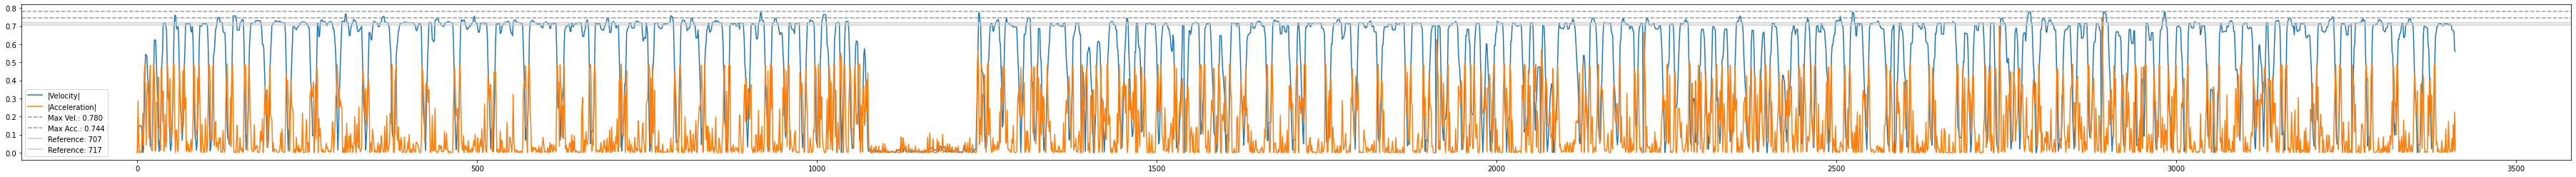

In [ ]:
t_test_pred = []
for split in tqdm(range(len(X_test_list))):
    t_test_i = np.array(t_test_list[split])
    t_test_pred.append(t_test_i)
t_test_pred = np.concatenate(t_test_pred, axis=0)

# get velocity and acceleration
vel_abs, acc_abs, acc_parallel, acc_perp = \
    get_vel_and_acc(y_test_pred, t_test_pred)

plt.figure(figsize=(64, 4))
plt.plot(vel_abs, label='|Velocity|')
plt.plot(acc_abs, label='|Acceleration|')
plt.axhline(np.max(vel_abs), ls='--', color='0.6', 
           label='Max Vel.: {:3.3f}'.format(np.max(vel_abs)))
plt.axhline(np.max(acc_abs), ls='--', color='0.6', 
           label='Max Acc.: {:3.3f}'.format(np.max(acc_abs)))
plt.axhline(.707, ls='-', color='.8', label='Reference: 707')
plt.axhline(.717, ls='-', color='.8', label='Reference: 717')
plt.legend()
plt.show()
    

In [ ]:
create_y_gif(
    y_pred=y_test_pred[::5], 
    y_true=None, 
    file_name='plots/gif_y_prediction.gif')